In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F

In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(torch.__version__)
print(device)
print(torch.cuda.device_count())
print(torch.cuda.current_device())
print(torch.cuda.device(0))
print(torch.cuda.get_device_name(0))
print(torch.version.cuda)

2.1.1
cuda:0
1
0
NVIDIA A100-PCIE-40GB MIG 2g.10gb
12.1


## Data Preprocessing

In [3]:
DATASET_FOLDER_NAME = 'caltech-101_top12'
dataset = torchvision.datasets.ImageFolder(root=DATASET_FOLDER_NAME)

In [4]:
from collections import Counter

def get_label_count(label_idxs):
    label_idxs_count = Counter(label_idxs)
    label_idxs_count = sorted(list(label_idxs_count.items()),key=lambda x:x[1] ,reverse=True)
    return label_idxs_count

label_count = get_label_count(dataset.targets)
label_count_topk = [(dataset.classes[x[0]], x[1]) for x in label_count][:20]
print(label_count_topk)
label_count_topk_total_count = sum([x[1] for x in label_count_topk])
print(label_count_topk_total_count)

[('airplanes', 800), ('Motorbikes', 798), ('Faces_easy', 435), ('watch', 239), ('Leopards', 200), ('bonsai', 128), ('car_side', 123), ('ketch', 114), ('chandelier', 107), ('hawksbill', 100), ('grand_piano', 99), ('brain', 98)]
3241


In [5]:
# Found minH, minW = 101, 128

# i=0
# for img, label in dataset:
#   i+=1
#   minH = min(img.shape[1], minH)
#   minW = min(img.shape[2], minW)

# print(minH, minW)

In [5]:
# get mean and std for dataset
import os
from time import time

class SquarePad:
    def __call__(self, image):
        max_wh = max(image.size)
        p_left, p_top = [(max_wh - s) // 2 for s in image.size]
        p_right, p_bottom = [max_wh - (s+pad) for s, pad in zip(image.size, [p_left, p_top])]
        padding = (p_left, p_top, p_right, p_bottom)
        return torchvision.transforms.functional.pad(image, padding, 0, 'constant')

def calc_mean_std(loader, N_CHANNELS = 3):
    before = time()
    mean = torch.zeros(3)
    std = torch.zeros(3)
    print('==> Computing mean and std..')
    for inputs, _labels in full_loader:
        for i in range(N_CHANNELS):
            mean[i] += inputs[:,i,:,:].mean()
            std[i] += inputs[:,i,:,:].std()
    mean.div_(len(dataset))
    std.div_(len(dataset))
    print('mean:', mean, 'std:', std)
    print("time elapsed: ", time()-before)
    return mean, std

IMAGE_SIZE = 128

dataset.transform = transforms.Compose([SquarePad(),
                                        transforms.ToTensor(),
                                        transforms.Resize((IMAGE_SIZE, IMAGE_SIZE), antialias=True)])

full_loader = torch.utils.data.DataLoader(dataset)

mean, std = calc_mean_std(full_loader)

==> Computing mean and std..
mean: tensor([0.3585, 0.3530, 0.3410]) std: tensor([0.3140, 0.3121, 0.3101])
time elapsed:  11.358381748199463


In [6]:
from sklearn.model_selection import train_test_split
import numpy as np
from torch.utils.data import Subset

# set seed
torch.manual_seed(123)

IMAGE_SIZE = 128

dataset.transform = transforms.Compose([SquarePad(),
                                        transforms.ToTensor(),
                                        transforms.Resize((IMAGE_SIZE, IMAGE_SIZE), antialias=True),
                                        transforms.CenterCrop(size=IMAGE_SIZE),
                                        transforms.Normalize(mean, std)])

labels = dataset.targets
print("Count of all data:", len(labels))

train_idx, val_test_idx = train_test_split(np.arange(len(labels)),
                                           test_size=0.2,
                                           shuffle=True,
                                           random_state=100,
                                           stratify=labels)

val_test_labels = [dataset.targets[x] for x in val_test_idx]

val_idx, test_idx = train_test_split(np.arange(len(val_test_labels)),
                                      test_size=0.5,
                                      shuffle=True,
                                      random_state=102,
                                      stratify=val_test_labels)

val_idx = [val_test_idx[x] for x in val_idx]
test_idx = [val_test_idx[x] for x in test_idx]

train_data_count = len(train_idx)
val_data_count = len(val_idx)
test_data_count = len(test_idx)

print("Count of train data:", train_data_count)
print("Count of val data:", val_data_count)
print("Count of test data:", test_data_count)

train_data = Subset(dataset, train_idx)
val_data = Subset(dataset, val_idx)
test_data = Subset(dataset, test_idx)
# assert no intersection
assert(len(set().intersection(train_idx, val_idx, test_idx))==0)

Count of all data: 3241
Count of train data: 2592
Count of val data: 324
Count of test data: 325


In [7]:
from collections import Counter

train_labels = [dataset.targets[x] for x in train_idx]
val_labels = [dataset.targets[x] for x in val_idx]
test_labels = [dataset.targets[x] for x in test_idx]

print(sorted(Counter(train_labels).items()))
print(sorted(Counter(val_labels).items()))
print(sorted(Counter(test_labels).items()))



[(0, 348), (1, 160), (2, 638), (3, 640), (4, 102), (5, 79), (6, 98), (7, 86), (8, 79), (9, 80), (10, 91), (11, 191)]
[(0, 43), (1, 20), (2, 80), (3, 80), (4, 13), (5, 10), (6, 12), (7, 11), (8, 10), (9, 10), (10, 11), (11, 24)]
[(0, 44), (1, 20), (2, 80), (3, 80), (4, 13), (5, 9), (6, 13), (7, 10), (8, 10), (9, 10), (10, 12), (11, 24)]


In [9]:
import matplotlib.pyplot as plt

def show_img_grid(images, nrow=5):
  grid_img = torchvision.utils.make_grid(images, nrow=nrow)
  plt.imshow(grid_img.permute(1, 2, 0))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([16, 3, 128, 128]) torch.Size([16])
Motorbikes


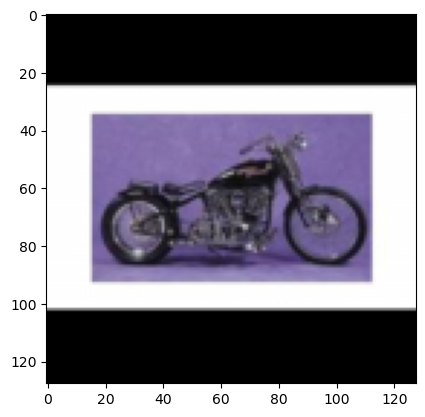

In [10]:
train_loader = torch.utils.data.DataLoader(train_data, batch_size=16, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_data, batch_size=16, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=16, shuffle=False)


x, y = next(iter(train_loader))
print(x.shape, y.shape)
show_img_grid(x[0]*std.view(3, 1, 1)+mean.view(3, 1, 1), 1)
image, label = x[0], y[0].item()
print(dataset.classes[label])

## CNN Class

In [11]:
# Model with x conv-relu-maxpool blocks and 2 fc layers

class ConvNet(nn.Module):
  def __init__(self, conv_layer_channels = [2, 4], conv_layer_sizes = [3, 3], hidden_layers=[128, 64], dropout_p=0.5, cin = 3):
    super(ConvNet, self).__init__()
    # make sure length is equal
    assert(len(conv_layer_channels)==len(conv_layer_sizes))
    # number of conv layers
    num_conv_layers = len(conv_layer_channels)
    # c[i] = input channels of ith layer, c[i+1] = output channels of ith layer
    c = [cin] + conv_layer_channels
    # create conv-relu-maxpool blocks
    conv_blocks = [nn.Sequential(
                        nn.Conv2d(c[i], c[i+1], conv_layer_sizes[i], padding='same', bias=True),
                        nn.ReLU(),
                        nn.MaxPool2d((2,2))
                    ) for i in range(num_conv_layers)]
    self.conv_block = nn.Sequential(*conv_blocks)
    # calculate width of feature map after conv blocks
    w = IMAGE_SIZE // 2**num_conv_layers
    
    # number of fc hidden layers
    num_fc_layers = len(hidden_layers)
    # h[i] = input dim of ith fc layer, h[i+1] = output dim of ith fc layer
    h = [conv_layer_channels[-1]*w*w] + hidden_layers
    fc_blocks = [nn.Sequential(
                        nn.Linear(h[i], h[i+1], bias=True),
                        nn.ReLU()
                    ) for i in range(num_fc_layers)]
    self.fc_block = nn.Sequential(*fc_blocks)
    # last fc layer that produces 12 class scores
    self.scoring = nn.Linear(h[-1], 12, bias=True)
    # dropout layer before fc layers
    self.dropout = nn.Dropout(p=dropout_p)

  def forward(self, x):
    x = self.conv_block(x)
    x = torch.flatten(x, 1) # flatten all dimensions except the batch dimension
    x = self.dropout(x)
    x = self.fc_block(x)
    x = self.scoring(x)
    return x



net = ConvNet()
print(net)

test_tensor = torch.randn(1, 3, IMAGE_SIZE, IMAGE_SIZE)
out = net(test_tensor)
print(out.shape)
print(out)

ConvNet(
  (conv_block): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 2, kernel_size=(3, 3), stride=(1, 1), padding=same)
      (1): ReLU()
      (2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    )
    (1): Sequential(
      (0): Conv2d(2, 4, kernel_size=(3, 3), stride=(1, 1), padding=same)
      (1): ReLU()
      (2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    )
  )
  (fc_block): Sequential(
    (0): Sequential(
      (0): Linear(in_features=4096, out_features=128, bias=True)
      (1): ReLU()
    )
    (1): Sequential(
      (0): Linear(in_features=128, out_features=64, bias=True)
      (1): ReLU()
    )
  )
  (scoring): Linear(in_features=64, out_features=12, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)
torch.Size([1, 12])
tensor([[-0.0744, -0.0708, -0.0978, -0.1102, -0.1246, -0.1030,  0.1026,  0.0281,
          0.0426,  0.1043, -0.1263,  0.0252]], grad_fn=<AddmmBackward0>)


In [12]:
# evaluation function

def eval(model, criterion, val_loader):
    total = correct = 0
    running_loss = 0.0
    with torch.no_grad():
        for data in val_loader:
            model.eval()
            images, labels = data
            images = images.to(device)
            labels = labels.to(device)
            
            scores = model(images)
            loss = criterion(scores, labels)
            
            running_loss += loss.item() * labels.size(0)
            
            _, predicted = torch.max(scores.data, 1)
            
            total += labels.size(0)
            
            correct += (predicted == labels).sum().item()
    return running_loss / total, 100 * correct // total

In [23]:
import torch.optim as optim
import torch

# set seed
torch.manual_seed(123)

# Early Stopper
class EarlyStopper:
    def __init__(self, patience=5, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = float('inf')

    def early_stop(self, validation_loss):
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0
        elif validation_loss > (self.min_validation_loss + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False

# Train loop
def train(model, train_loader, epochs, optimizer, criterion, val_loader, print_every=1, print_time=False):
    early_stopper = EarlyStopper(patience=10, min_delta=0)
    num_iters = epochs * len(train_loader)
    iter = 0
    train_loss_history = []
    train_acc_history = []
    val_loss_history = []
    val_acc_history = []
    before = time()
    for epoch in range(epochs):
        total = correct = 0
        running_loss = 0.0
        for i, data in enumerate(train_loader):
            iter+=1
            model.train()
            images, labels = data
            images = images.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()

            scores = model(images)
            loss = criterion(scores, labels)
            
            running_loss += loss.item() * labels.size(0)

            _, predicted = torch.max(scores.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            loss.backward()
            optimizer.step()
            
        train_loss = running_loss / total
        train_acc = 100 * correct // total
        
        val_loss, val_accuracy = eval(model, criterion, val_loader)
        
        if epoch % print_every==0 or epoch==epochs-1:
            print(f'[Epoch {epoch + 1}] training loss and accuracy: {train_loss:.3f} {train_acc} %')
            print(f'[Epoch {epoch + 1}] validation loss and accuracy: {val_loss:.3f} {val_accuracy} %')
        
        train_loss_history.append(train_loss)
        train_acc_history.append(train_acc)
        val_loss_history.append(val_loss)
        val_acc_history.append(val_accuracy)
        
        
        if early_stopper.early_stop(val_loss):             
            break
        
    if print_time:
        print("time elapsed: ", time()-before)
    return train_loss_history, train_acc_history, val_loss_history, val_acc_history



In [24]:
# Grid search function
def grid_search(models, hyperparameters, train_loader, val_loader, NUM_EPOCHS):
    before = time()
    # stores best model and hyperparameter
    best_model_hyperparam = {
        'model': None,
        'lr': None,
        'momentum': None,
        'weight_decay': None
    }
    # stores best validation accuracy
    best_val_acc = -1
    
    lrs = hyperparameters['lr']
    momentums = hyperparameters['momentum']
    weight_decays = hyperparameters['weight_decay']
    for i, model in enumerate(models):
        for lr in lrs:
            for momentum in momentums:
                for weight_decay in weight_decays:
                    # init model
                    net = ConvNet(*model)
                    net.to(device)
                    print(f'Model {i} with learning rate={lr}, momentum={momentum}, weight_decay={weight_decay}')
                    
                    # init loss and optimizer
                    criterion = nn.CrossEntropyLoss()
                    optimizer = optim.SGD(net.parameters(), lr=lr, momentum=momentum, weight_decay=weight_decay)
                    
                    # train
                    train_loss_history, train_acc_history, val_loss_history, val_acc_history = \
                        train(net, train_loader, NUM_EPOCHS, optimizer, criterion, val_loader, print_every=5, print_time=False)
                    
                    # update best_model_hyperparam based on max validation accuracy
                    max_val_acc = np.max(val_acc_history)
                    if max_val_acc > best_val_acc:
                        best_val_acc = max_val_acc
                        best_model_hyperparam = {
                            'model': model,
                            'lr': lr,
                            'momentum': momentum,
                            'weight_decay': weight_decay
                        }
                    print(f'Best validation accuracy:', max_val_acc, '%')
                    print('======================================================')
    print('Best model and hyperparameter:', best_model_hyperparam)
    print('Best validation accuracy:', best_val_acc, '%')
    print("time elapsed: ", time()-before)
    return best_model_hyperparam

## Grid Search Hyperparameters

In [30]:
torch.manual_seed(123)

train_loader = torch.utils.data.DataLoader(train_data, batch_size=32,shuffle=True)
val_loader = torch.utils.data.DataLoader(val_data, batch_size=32, shuffle=False)

hyperparameters = {
    'lr': [1e-2, 1e-3, 5e-4],
    'momentum': [0.9],
    'weight_decay': [0, 1e-2]
}

models = [
    [[4, 8], [3, 3], [32], 0.2, 3],
    [[4, 8], [5, 5], [64], 0.2, 3],
    [[16, 32], [5, 3], [128], 0.2, 3],
    [[8, 32, 64], [5, 3, 3], [128], 0.5, 3],
    [[12, 64, 128], [5, 3, 3], [512, 64], 0.5, 3],
]

NUM_EPOCHS=50

best_model_hyperparam = grid_search(models, hyperparameters, train_loader, val_loader, NUM_EPOCHS)

Model 0 with learning rate=0.01, momentum=0.9, weight_decay=0
[Epoch 1] training loss and accuracy: 1.165 63 %
[Epoch 1] validation loss and accuracy: 0.730 77 %
[Epoch 6] training loss and accuracy: 0.121 96 %
[Epoch 6] validation loss and accuracy: 0.387 88 %
[Epoch 11] training loss and accuracy: 0.016 99 %
[Epoch 11] validation loss and accuracy: 0.460 90 %
[Epoch 16] training loss and accuracy: 0.000 100 %
[Epoch 16] validation loss and accuracy: 0.485 91 %
Best validation accuracy: 91 %
Model 0 with learning rate=0.01, momentum=0.9, weight_decay=0.01
[Epoch 1] training loss and accuracy: 1.356 58 %
[Epoch 1] validation loss and accuracy: 0.878 73 %
[Epoch 6] training loss and accuracy: 0.199 93 %
[Epoch 6] validation loss and accuracy: 0.500 87 %
[Epoch 11] training loss and accuracy: 0.066 98 %
[Epoch 11] validation loss and accuracy: 0.470 89 %
[Epoch 16] training loss and accuracy: 0.061 98 %
[Epoch 16] validation loss and accuracy: 0.382 90 %
[Epoch 21] training loss and accu

In [ ]:
import pickle
import os

with open('best_model_hyperparam', 'wb') as handle:
    pickle.dump(best_model_hyperparam, handle)




## Train using best model and hyperparams

In [29]:
# set seed
torch.manual_seed(123)
best_model = [[4, 8], [5, 5], [64], 0.2, 3]
best_net = ConvNet(*best_model)
best_net.to(device)
print(best_net)

# init loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(best_net.parameters(), lr=0.01, momentum=0.9, weight_decay=0.01)

NUM_EPOCHS = 50

# train
train_loss_history, train_acc_history, val_loss_history, val_acc_history = \
    train(best_net, train_loader, NUM_EPOCHS, optimizer, criterion, val_loader, print_every=1, print_time=True)

ConvNet(
  (conv_block): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 4, kernel_size=(5, 5), stride=(1, 1), padding=same)
      (1): ReLU()
      (2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    )
    (1): Sequential(
      (0): Conv2d(4, 8, kernel_size=(5, 5), stride=(1, 1), padding=same)
      (1): ReLU()
      (2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    )
  )
  (fc_block): Sequential(
    (0): Sequential(
      (0): Linear(in_features=8192, out_features=64, bias=True)
      (1): ReLU()
    )
  )
  (scoring): Linear(in_features=64, out_features=12, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)
[Epoch 1] training loss and accuracy: 1.104 65 %
[Epoch 1] validation loss and accuracy: 1.045 68 %
[Epoch 2] training loss and accuracy: 0.608 80 %
[Epoch 2] validation loss and accuracy: 0.591 84 %
[Epoch 3] training loss and accuracy: 0.457 85 %
[Epoch 3] validation loss and accu

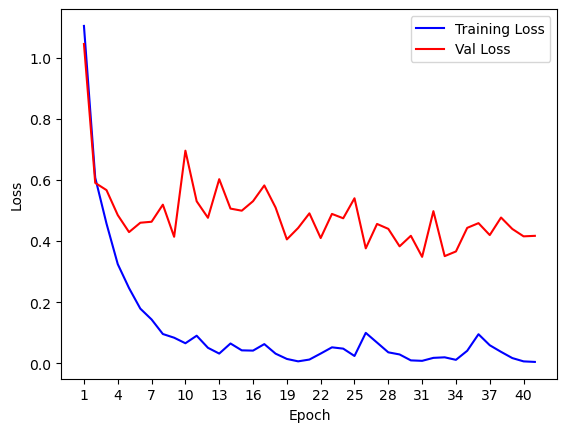

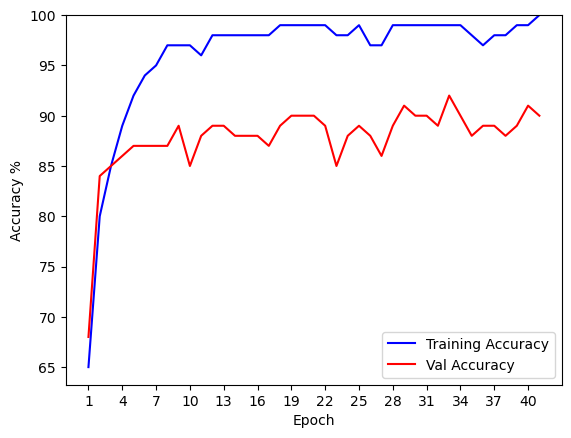

In [33]:
# Plot train and val loss curve
epoch_count = len(train_loss_history)
plt.plot(range(1, epoch_count+1), train_loss_history, 'b')
plt.plot(range(1, epoch_count+1), val_loss_history, 'r')
plt.legend(['Training Loss', 'Val Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.xticks(range(1, epoch_count+1, 3))
plt.savefig('loss-curve.png')
plt.show();

# Plot train and val acc curve
plt.plot(range(1, epoch_count+1), train_acc_history, 'b')
plt.plot(range(1, epoch_count+1), val_acc_history, 'r')
plt.legend(['Training Accuracy', 'Val Accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy %')
plt.xticks(range(1, epoch_count+1, 3))
plt.ylim(None, 100)
plt.savefig('acc-curve.png')
plt.show();


In [31]:
test_loader = torch.utils.data.DataLoader(test_data, batch_size=32, shuffle=False)
loss, accuracy = eval(best_net, criterion, test_loader)
print(f'Accuracy of the network on the test images: {accuracy} %')

Accuracy of the network on the test images: 90 %
